In [1]:
print("hello world")

hello world


Training a CNN for multi-class multi-labeling classification (MCMLC) on 512 * 512 * 3 retinal images over the 3 mains labels beeing DR, MH, ODC according to the EDA. 

In [2]:
import os
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)


from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset
from classes.CNNMultiClassMultiLabeling import CNNMultiClassMultiLabeling

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Transformation

In [3]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((512, 512)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## 2. Data Loading


In [4]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)


## 3. Model init

In [6]:
# Initialisation
NUMBER_OF_LABELS = 4  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=NUMBER_OF_LABELS).to(device) # ["DR", "MH", "ODC"] and normal

## 4. Loss definition

In [7]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_train_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30  

In [9]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)

    # Print metrics
    get_device_properties = torch.cuda.get_device_properties(0).total_memory / 1024**3
    memory_allocated = torch.cuda.memory_allocated() / 1024**3
    memory_reserved = torch.cuda.memory_reserved() / 1024**3
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties, memory_allocated, memory_reserved
    )

    # Early stopping
    if epoch > 5:
        if (best_train_loss - train_loss) > min_delta:
            best_train_loss = train_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)


Epoch number: 0


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 9.3730 | Train Accuracy: 0.6447 | Train F1-score: 0.3105 | Train ROC-AUC: 0.5508 |
| Test Loss:  0.6501 | Test Accuracy:  0.7067 | Test F1-score:  0.2895 | Test ROC-AUC:  0.6616 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.9743 | Train Accuracy: 0.6486 | Train F1-score: 0.3591 | Train ROC-AUC: 0.5774 |
| Test Loss:  0.5345 | Test Accuracy:  0.7579 | Test F1-score:  0.3648 | Test ROC-AUC:  0.7334 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6292 | Train Accuracy: 0.7041 | Train F1-score: 0.3549 | Train ROC-AUC: 0.6167 |
| Test Loss:  0.5211 | Test Accuracy:  0.7646 | Test F1-score:  0.4422 | Test ROC-AUC:  0.7474 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6399 | Train Accuracy: 0.7202 | Train F1-score: 0.2422 | Train ROC-AUC: 0.5898 |
| Test Loss:  0.5364 | Test Accuracy:  0.7610 | Test F1-score:  0.4006 | Test ROC-AUC:  0.7296 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6091 | Train Accuracy: 0.7380 | Train F1-score: 0.2651 | Train ROC-AUC: 0.6212 |
| Test Loss:  0.5417 | Test Accuracy:  0.7835 | Test F1-score:  0.5209 | Test ROC-AUC:  0.7531 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5933 | Train Accuracy: 0.7465 | Train F1-score: 0.2797 | Train ROC-AUC: 0.6357 |
| Test Loss:  0.5402 | Test Accuracy:  0.7933 | Test F1-score:  0.5108 | Test ROC-AUC:  0.7625 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6031 | Train Accuracy: 0.7467 | Train F1-score: 0.2532 | Train ROC-AUC: 0.6311 |
| Test Loss:  0.5572 | Test Accuracy:  0.7616 | Test F1-score:  0.3622 | Test ROC-AUC:  0.7403 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.6052 | Train Accuracy: 0.7394 | Train F1-score: 0.1891 | Train ROC-AUC: 0.6236 |
| Test Loss:  0.5425 | Test Accuracy:  0.7713 | Test F1-score:  0.3883 | Test ROC-AUC:  0.7402 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5904 | Train Accuracy: 0.7429 | Train F1-score: 0.1922 | Train ROC-AUC: 0.6213 |
| Test Loss:  0.5306 | Test Accuracy:  0.7854 | Test F1-score:  0.4377 | Test ROC-AUC:  0.7664 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5800 | Train Accuracy: 0.7480 | Train F1-score: 0.2245 | Train ROC-AUC: 0.6394 |
| Test Loss:  0.5218 | Test Accuracy:  0.7640 | Test F1-score:  0.4334 | Test ROC-AUC:  0.7244 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5743 | Train Accuracy: 0.7471 | Train F1-score: 0.1948 | Train ROC-AUC: 0.6439 |
| Test Loss:  0.5091 | Test Accuracy:  0.7787 | Test F1-score:  0.4337 | Test ROC-AUC:  0.7501 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5788 | Train Accuracy: 0.7522 | Train F1-score: 0.2139 | Train ROC-AUC: 0.6416 |
| Test Loss:  0.5070 | Test Accuracy:  0.7732 | Test F1-score:  0.4224 | Test ROC-AUC:  0.7368 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5655 | Train Accuracy: 0.7535 | Train F1-score: 0.2312 | Train ROC-AUC: 0.6402 |
| Test Loss:  0.5147 | Test Accuracy:  0.7732 | Test F1-score:  0.3882 | Test ROC-AUC:  0.7410 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5472 | Train Accuracy: 0.7576 | Train F1-score: 0.2729 | Train ROC-AUC: 0.6744 |
| Test Loss:  0.5184 | Test Accuracy:  0.7823 | Test F1-score:  0.4000 | Test ROC-AUC:  0.7467 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 20/20 [00:36<00:00,  1.85s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5576 | Train Accuracy: 0.7529 | Train F1-score: 0.2232 | Train ROC-AUC: 0.6341 |
| Test Loss:  0.5038 | Test Accuracy:  0.7866 | Test F1-score:  0.4599 | Test ROC-AUC:  0.7541 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5732 | Train Accuracy: 0.7469 | Train F1-score: 0.1761 | Train ROC-AUC: 0.6102 |
| Test Loss:  0.5226 | Test Accuracy:  0.7726 | Test F1-score:  0.3398 | Test ROC-AUC:  0.7097 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5576 | Train Accuracy: 0.7469 | Train F1-score: 0.1730 | Train ROC-AUC: 0.6188 |
| Test Loss:  0.5184 | Test Accuracy:  0.7646 | Test F1-score:  0.3413 | Test ROC-AUC:  0.7144 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5432 | Train Accuracy: 0.7584 | Train F1-score: 0.2479 | Train ROC-AUC: 0.6473 |
| Test Loss:  0.5047 | Test Accuracy:  0.7829 | Test F1-score:  0.3966 | Test ROC-AUC:  0.7531 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5602 | Train Accuracy: 0.7504 | Train F1-score: 0.1855 | Train ROC-AUC: 0.6203 |
| Test Loss:  0.4954 | Test Accuracy:  0.7768 | Test F1-score:  0.4245 | Test ROC-AUC:  0.7478 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5400 | Train Accuracy: 0.7584 | Train F1-score: 0.2533 | Train ROC-AUC: 0.6521 |
| Test Loss:  0.4853 | Test Accuracy:  0.7872 | Test F1-score:  0.4672 | Test ROC-AUC:  0.7662 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5305 | Train Accuracy: 0.7625 | Train F1-score: 0.2700 | Train ROC-AUC: 0.6636 |
| Test Loss:  0.4914 | Test Accuracy:  0.7878 | Test F1-score:  0.4494 | Test ROC-AUC:  0.7555 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5474 | Train Accuracy: 0.7522 | Train F1-score: 0.2000 | Train ROC-AUC: 0.6320 |
| Test Loss:  0.5096 | Test Accuracy:  0.7616 | Test F1-score:  0.4138 | Test ROC-AUC:  0.7165 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 22


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5446 | Train Accuracy: 0.7533 | Train F1-score: 0.2215 | Train ROC-AUC: 0.6392 |
| Test Loss:  0.5119 | Test Accuracy:  0.7652 | Test F1-score:  0.2987 | Test ROC-AUC:  0.7304 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 23


100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5558 | Train Accuracy: 0.7508 | Train F1-score: 0.1961 | Train ROC-AUC: 0.6430 |
| Test Loss:  0.5066 | Test Accuracy:  0.7713 | Test F1-score:  0.3268 | Test ROC-AUC:  0.7415 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 24


100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5228 | Train Accuracy: 0.7625 | Train F1-score: 0.2700 | Train ROC-AUC: 0.6731 |
| Test Loss:  0.5050 | Test Accuracy:  0.7713 | Test F1-score:  0.3740 | Test ROC-AUC:  0.7376 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 25


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5368 | Train Accuracy: 0.7590 | Train F1-score: 0.2520 | Train ROC-AUC: 0.6622 |
| Test Loss:  0.4818 | Test Accuracy:  0.7835 | Test F1-score:  0.4152 | Test ROC-AUC:  0.7369 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 26


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5587 | Train Accuracy: 0.7476 | Train F1-score: 0.1713 | Train ROC-AUC: 0.6189 |
| Test Loss:  0.4946 | Test Accuracy:  0.7799 | Test F1-score:  0.3765 | Test ROC-AUC:  0.7351 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 27


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5401 | Train Accuracy: 0.7573 | Train F1-score: 0.2262 | Train ROC-AUC: 0.6430 |
| Test Loss:  0.4909 | Test Accuracy:  0.7854 | Test F1-score:  0.4267 | Test ROC-AUC:  0.7672 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 28


100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5301 | Train Accuracy: 0.7643 | Train F1-score: 0.2580 | Train ROC-AUC: 0.6552 |
| Test Loss:  0.4882 | Test Accuracy:  0.7793 | Test F1-score:  0.3671 | Test ROC-AUC:  0.7554 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 29


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.5100 | Train Accuracy: 0.7714 | Train F1-score: 0.3229 | Train ROC-AUC: 0.6896 |
| Test Loss:  0.4714 | Test Accuracy:  0.7927 | Test F1-score:  0.4671 | Test ROC-AUC:  0.7693 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 2.02 Go          | cached: 8.99 Go       |
------------------------------------------------------------------------------------------------


In [10]:
torch.save(model.state_dict(), '../Models/model_simple_cnn_mcmlc_retina.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv')

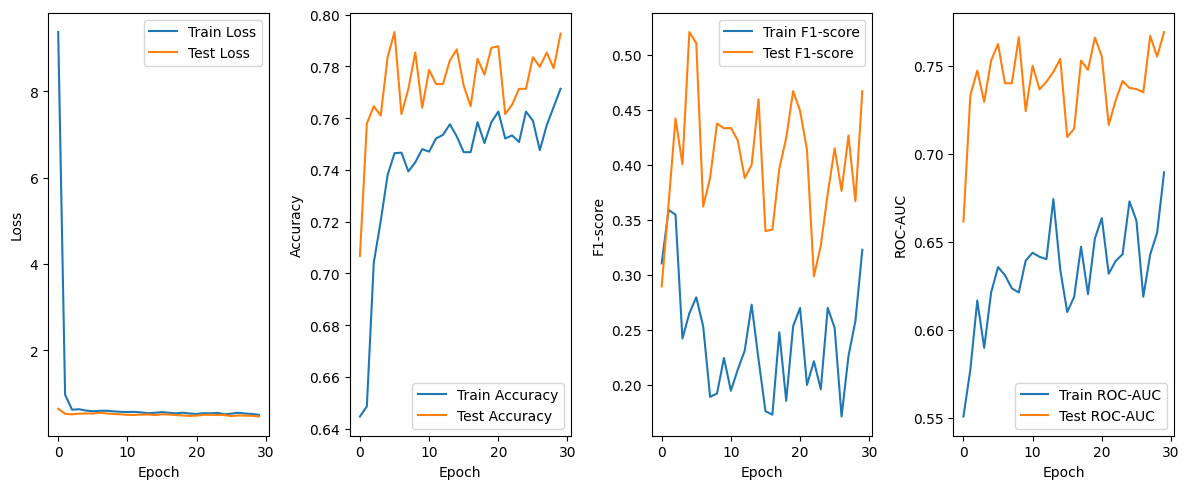

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina_zoomed.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=True
)

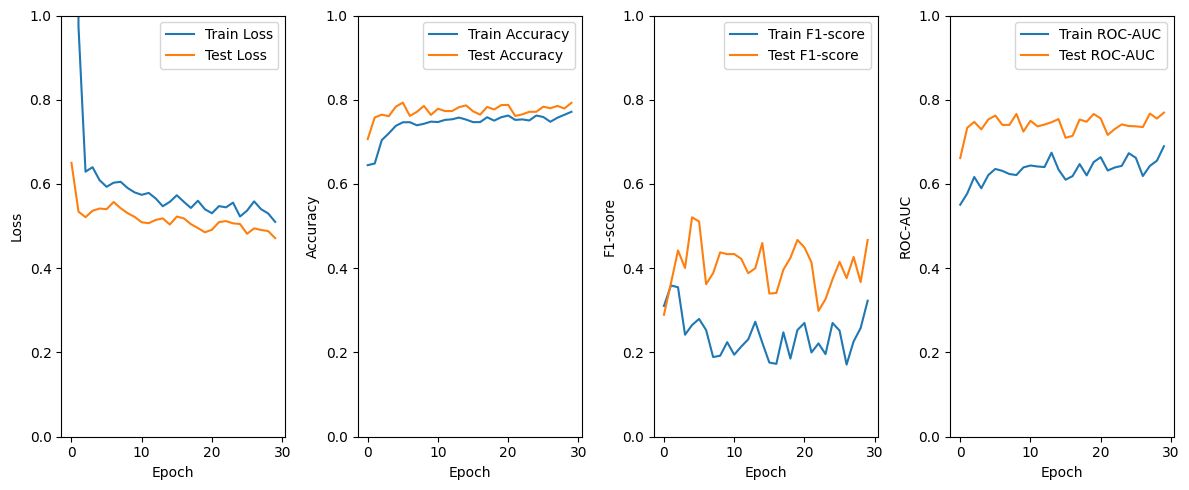

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=False
)

## 7. Model evaluation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=4).to(device)
model.load_state_dict(torch.load('../Models/model_simple_cnn_mcmlc_retina.pth', weights_only=True))
criterion = nn.BCEWithLogitsLoss() 

In [18]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(
    model=model, val_loader=val_loader, criterion=criterion, 
    device=device, num_labels=NUMBER_OF_LABELS)

In [19]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.4944 | Validation Accuracy: 0.7693 | Validation F1-score: 0.3813 | Validation ROC-AUC: 0.7319
